In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cartopy
import cmaps
import proplot as pplt
import cnmaps
from scipy.stats import linregress
from minisom import MiniSom
from scipy.spatial import distance
import proplot as pplt

import os
os.chdir('/Users/zeqinhuang/Documents/paper/anomalous_PREC')

import warnings
warnings.filterwarnings('ignore')

# SOM patterns by observation

In [45]:
prec_ano = xr.open_dataarray('dataset/china_daily_precipitation_summer_anomalies_1961_2018.nc')
ano_date = pd.read_csv('output/ano_dates_95th.csv',index_col=0,header=0)
ano_date = pd.to_datetime(ano_date.index,format='%Y-%m-%d')
prec_ano_data = prec_ano.sel(time = ano_date)

lon0 = prec_ano_data.coords['lon']
lat0 = prec_ano_data.coords['lat']

data_stack = prec_ano_data.stack(z=('lon','lat'))
data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
data_stack = data_stack_del_nan.values
data_stack = pd.DataFrame(data_stack)
data_stack = data_stack.to_numpy()

som = MiniSom(2, 3, data_stack.shape[1], sigma=1, learning_rate=.5,
                neighborhood_function='gaussian', random_seed=1)
som.train(data_stack, 80000) 
winners = []

som_weight_pattern1 = som.get_weights()[0,0,:]
som_weight_pattern2 = som.get_weights()[0,1,:]
som_weight_pattern3 = som.get_weights()[0,2,:]
som_weight_pattern4 = som.get_weights()[1,0,:]
som_weight_pattern5 = som.get_weights()[1,1,:]
som_weight_pattern6 = som.get_weights()[1,2,:]

# m_neurons x n_neurons SOM analysis for all anomalous precipitation dates

In [87]:
def som_analysis(data,n_neurons,m_neurons):

    lon0 = data.coords['lon']
    lat0 = data.coords['lat']

    data_stack = data.stack(z=('lon','lat'))
    data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
    data_stack = data_stack_del_nan.values
    data_stack = pd.DataFrame(data_stack)
    data_stack = data_stack.to_numpy()
 
    som = MiniSom(n_neurons, m_neurons, data_stack.shape[1], sigma=1, learning_rate=.5,
                  neighborhood_function='gaussian', random_seed=1)
    # som.pca_weights_init(data_stack)
    som.train(data_stack, 8000) # trains the SOM with 10000 iterations

    proj = pplt.Proj('pcarree', lon_0=180)
    fig, ax = pplt.subplots(ncols = m_neurons, nrows = n_neurons,share=3,wspace=(0),hspace=(0),proj = proj,width = 10)
    levels = [-30 + 3 * i for i in range(21)]
    cmap1 = cmaps.BlRe_r

    for i in range(n_neurons):
        for j in range(m_neurons):
            pattern1_flatten = som.get_weights()[i,j,:]
            pattern1 = data_stack_del_nan[0,:]
            pattern1.values = pattern1_flatten
            pattern1 = pattern1.unstack()
            pattern1 = pattern1.transpose('lat','lon')
            pattern1 = pattern1.sortby('lat',ascending=True)
            pattern1 = pattern1.sortby('lon',ascending=True)
            pattern1 = pattern1.values
            pattern1 = np.insert(pattern1,3,np.nan,axis=0)

            ax_num = i*m_neurons+j
            p1 = ax[ax_num].contourf(lon0,lat0,pattern1,levels = levels, alpha=0.75, 
                                extend = 'both',cmap=cmap1)
            ax[ax_num].format(lonlim=(lon0.min().values,lon0.max().values), latlim=(lat0.min().values,lat0.max().values),
                        coast=True, borders=True, labels=True, lonlines=20, latlines=10)

    cbar = fig.colorbar(p1,loc='b',width='0.75em',length=0.6)

# SOM applied to CESM2 simulation

In [88]:
prec_ano = xr.open_dataarray('output/historical_pr_CESM2_1961_2014_summer_anomalies.nc')
hist_time = pd.date_range(start='1961-01-01',end='2014-12-31',freq='D')
hist_time = hist_time[(hist_time.month > 4) & (hist_time.month < 11)]
prec_ano['time'] = hist_time
ano_date = pd.read_csv('output/ano_dates_95th_CESM2.csv',index_col=0,header=0)
ano_date = pd.to_datetime(ano_date.index,format='%Y-%m-%d')
prec_ano_95th = prec_ano.sel(time = ano_date)

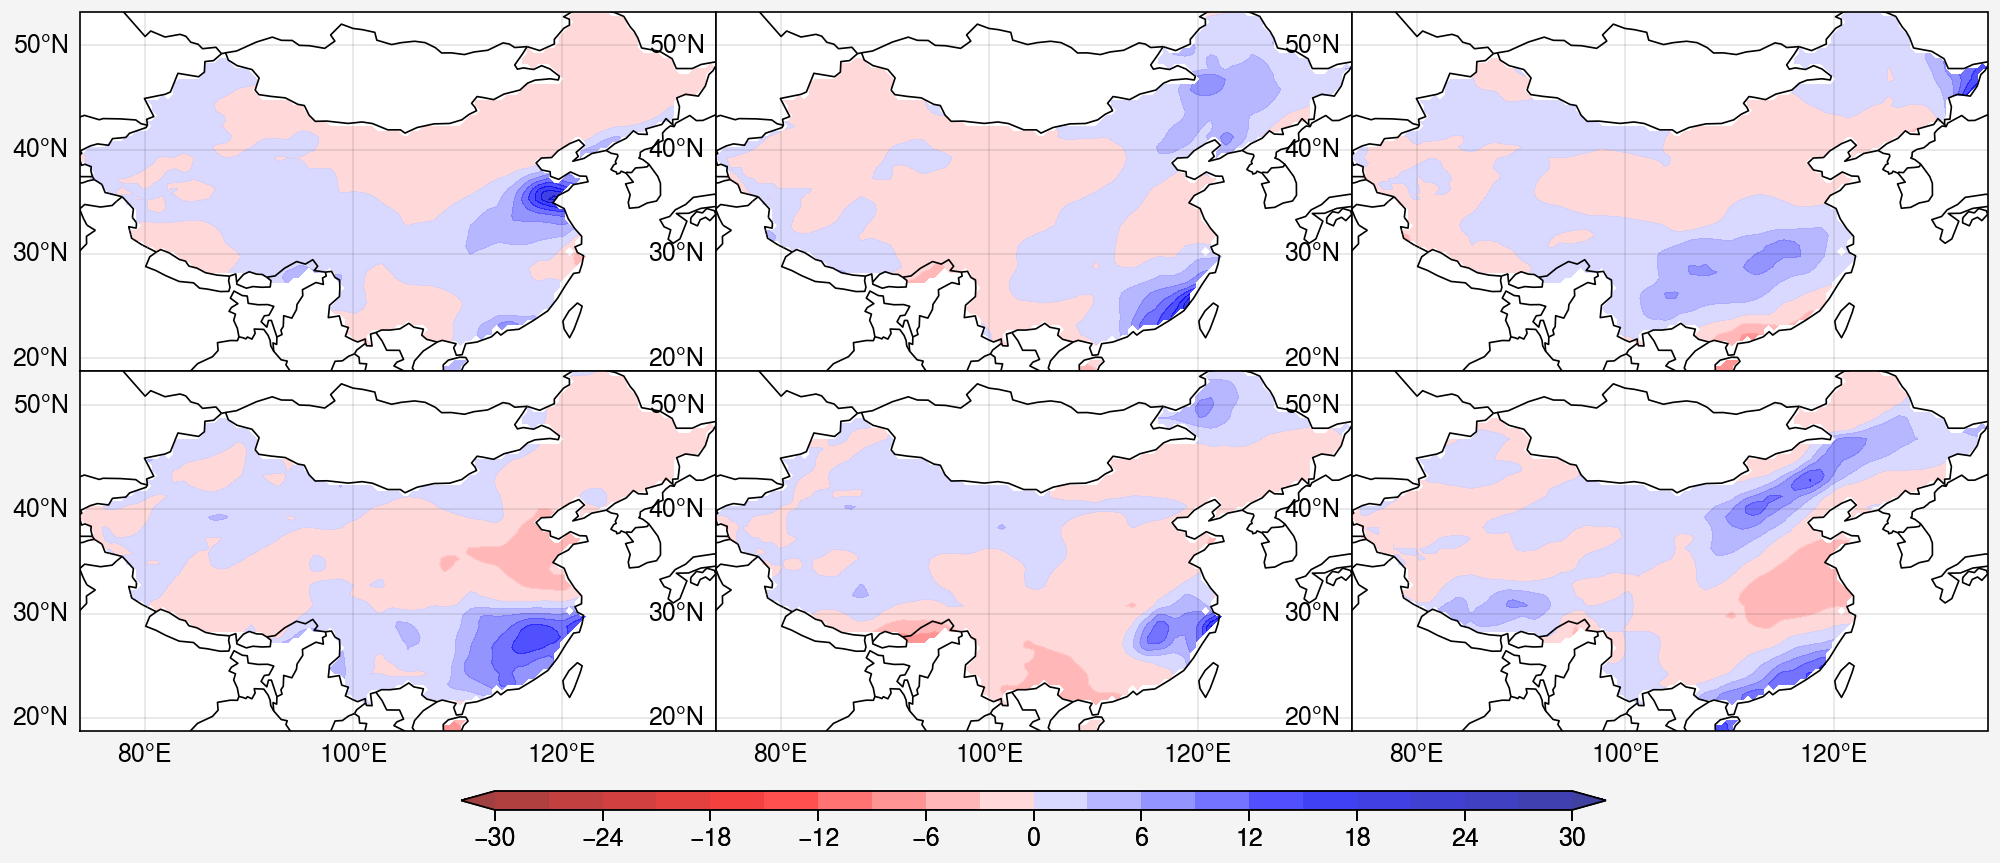

In [89]:
som_analysis(prec_ano_95th,2,3)

## SOM pattern statistics

In [48]:
def determine_winner_1(prec_ano_data):
    # determine winner by applying SOM analysis to the CMIP6 historical simulation
    data_stack = prec_ano_data.stack(z=('lon','lat'))
    data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
    data_stack = data_stack_del_nan.values
    data_stack = pd.DataFrame(data_stack)
    data_stack = data_stack.to_numpy()
 
    som = MiniSom(2, 3, data_stack.shape[1], sigma=1, learning_rate=.5,
                  neighborhood_function='gaussian', random_seed=1)
    som.train(data_stack, 8000) 
    winners = []
   
    for i in range(len(data_stack)):
        dist1 = distance.euclidean(data_stack[i],som.get_weights()[0,0,:])
        dist2 = distance.euclidean(data_stack[i],som.get_weights()[0,1,:])
        dist3 = distance.euclidean(data_stack[i],som.get_weights()[0,2,:])
        dist4 = distance.euclidean(data_stack[i],som.get_weights()[1,0,:])
        dist5 = distance.euclidean(data_stack[i],som.get_weights()[1,1,:])
        dist6 = distance.euclidean(data_stack[i],som.get_weights()[1,2,:])
        dists = np.array([dist1,dist2,dist3,dist4,dist5,dist6])
        winner = dists.argmin()
        winners.append(winner)

    return winners

In [52]:
def determine_winner_2(prec_ano_data):
    # determine winner by calculating the distance between the daily precipitation field and the six groups that were identified from observations
    data_stack = prec_ano_data.stack(z=('lon','lat'))
    data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
    data_stack = data_stack_del_nan.values
    data_stack = pd.DataFrame(data_stack)
    data_stack = data_stack.to_numpy()
 
    som = MiniSom(2, 3, data_stack.shape[1], sigma=1, learning_rate=.5,
                  neighborhood_function='gaussian', random_seed=1)
    som.train(data_stack, 8000) 
    winners = []
   
    for i in range(len(data_stack)):
        corr1 = np.corrcoef(data_stack[i],som_weight_pattern1)[0,1]
        corr2 = np.corrcoef(data_stack[i],som_weight_pattern2)[0,1]
        corr3 = np.corrcoef(data_stack[i],som_weight_pattern3)[0,1]
        corr4 = np.corrcoef(data_stack[i],som_weight_pattern4)[0,1]
        corr5 = np.corrcoef(data_stack[i],som_weight_pattern5)[0,1]
        corr6 = np.corrcoef(data_stack[i],som_weight_pattern6)[0,1]
        dist1 = distance.euclidean(data_stack[i],som_weight_pattern1)
        dist2 = distance.euclidean(data_stack[i],som_weight_pattern2)
        dist3 = distance.euclidean(data_stack[i],som_weight_pattern3)
        dist4 = distance.euclidean(data_stack[i],som_weight_pattern4)
        dist5 = distance.euclidean(data_stack[i],som_weight_pattern5)
        dist6 = distance.euclidean(data_stack[i],som_weight_pattern6)
        
        dists = np.array([corr1/dist1,corr2/dist2,corr3/dist3,corr4/dist4,corr5/dist5,corr6/dist6])
        winner = dists.argmax()
        winners.append(winner)

    return winners

In [37]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import transform
from cnmaps import get_map, draw_map, clip_contours_by_map
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

# data for drawing South China sea
with open('dataset/CN_border_shapefile/CN-border-L1.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]

river = shpreader.Reader('dataset/River_shapefile/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.7)

In [60]:
winner = determine_winner_1(prec_ano_95th)
winner = np.array(winner)

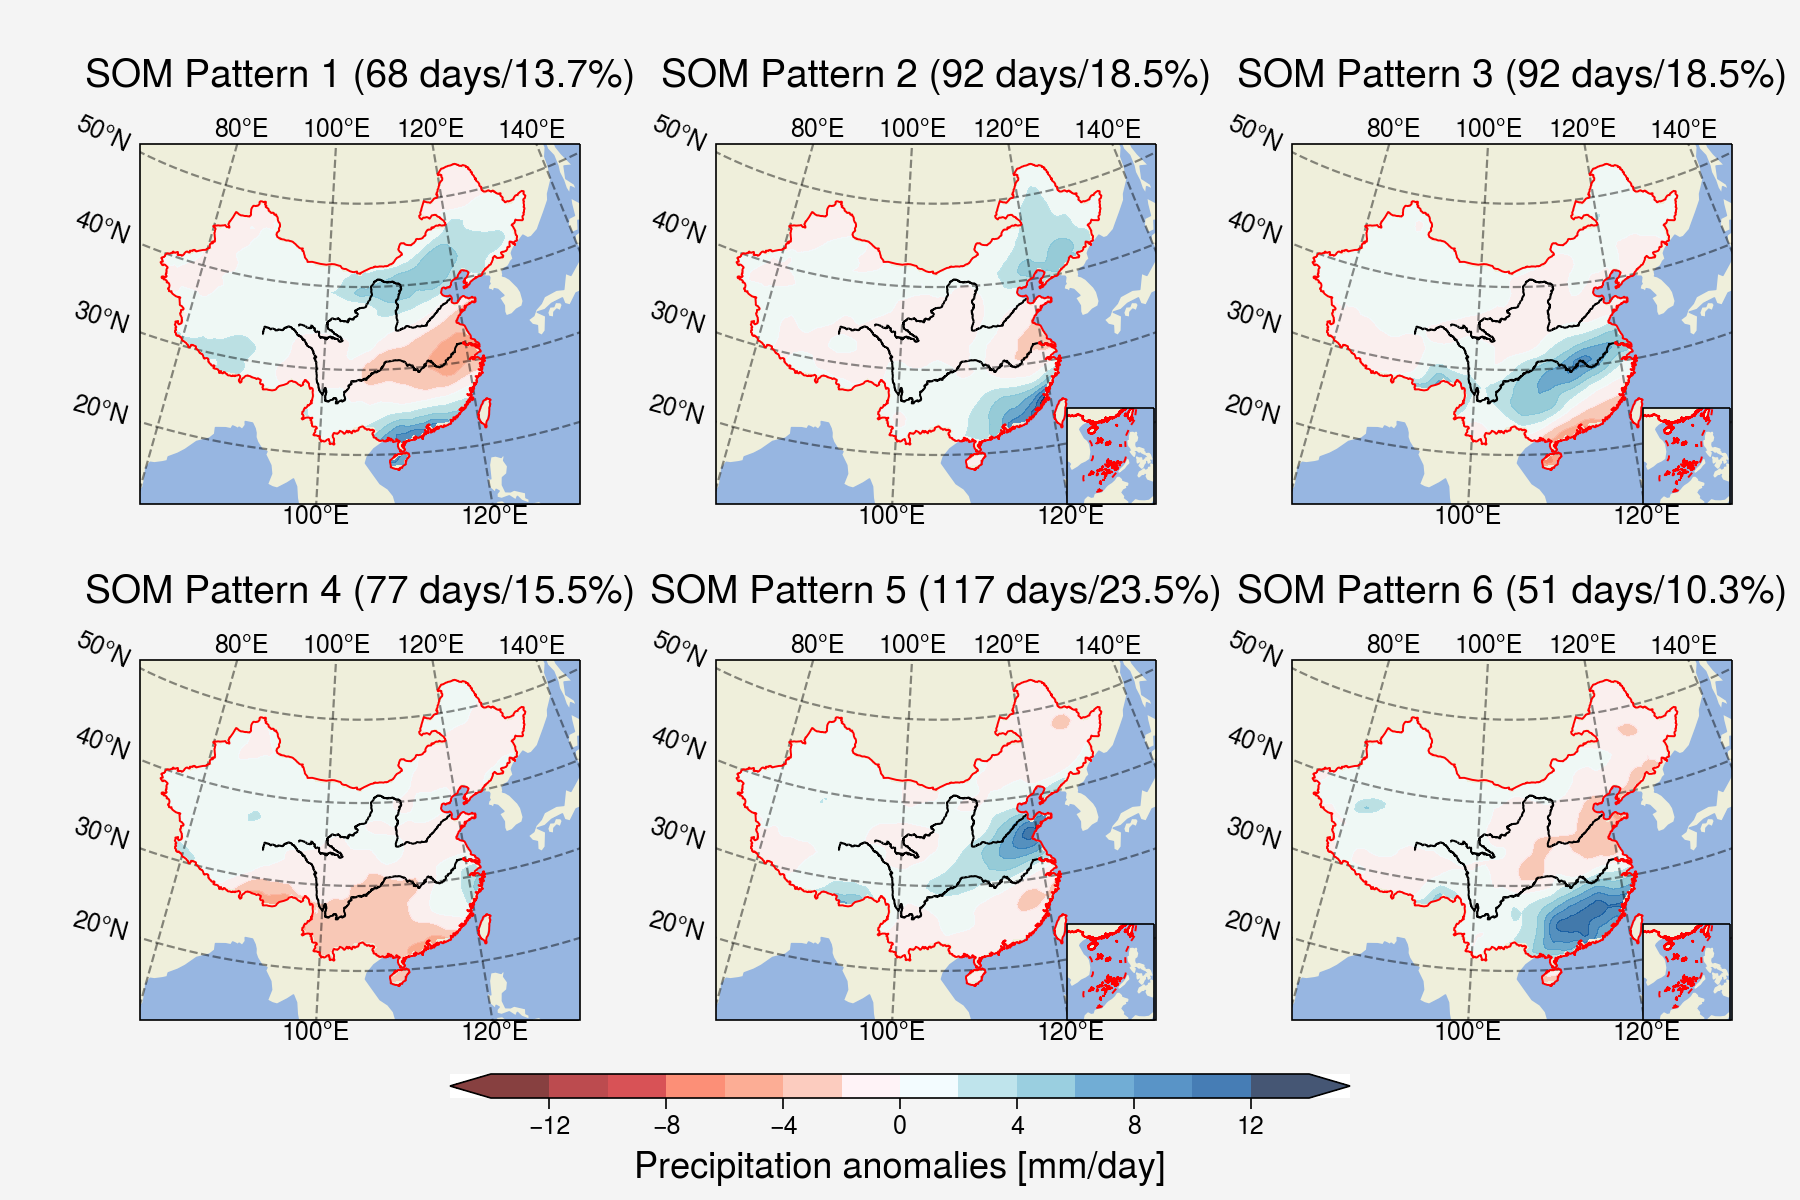

In [62]:
# determine winner by applying SOM analysis to the CMIP6 historical simulation
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
levels = [-14 + 2 * i for i in range(15)]
# cmap1 = cmaps.temp_diff_18lev_r
cmap1 = cmaps.temp_19lev_r

axes_locs = [
    [0.05,0.58,0.3,0.3],
    [0.37,0.58,0.3,0.3],
    [0.69,0.58,0.3,0.3],
    [0.05,0.15,0.3,0.3],
    [0.37,0.15,0.3,0.3],
    [0.69,0.15,0.3,0.3],
]
subaxes_locs = [
    [0.22 + 0.027, 0.58, 0.1, 0.08],
    [0.55 + 0.017, 0.58, 0.1, 0.08],
    [0.88 + 0.007, 0.58, 0.1, 0.08],
    [0.22 + 0.027, 0.15, 0.1, 0.08],
    [0.55 + 0.017, 0.15, 0.1, 0.08],
    [0.88 + 0.007, 0.15, 0.1, 0.08]
]
types = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

fig = plt.figure(figsize = (9,6))
for i in range(6):
    if i == 0:
        a = 4
        loc = axes_locs[a]
    elif i == 1:
        a = 1
        loc = axes_locs[a]
    elif i == 2:
        a = 2
        loc = axes_locs[a]
    elif i == 3:
        a = 5
        loc = axes_locs[a]
    elif i == 4:
        a = 3
        loc = axes_locs[a]
    elif i == 5:
        a = 0
        loc = axes_locs[a]
    ax1 = fig.add_axes(loc, projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    ax1.set_title('SOM Pattern '+str(a + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)
    # ax1.set_title(types[i]+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    sub_ax = fig.add_axes(subaxes_locs[i], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
    sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
    sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
    for line in borders:
        sub_ax.plot(line[0::2], line[1::2], '-', color='r',transform=ccrs.Geodetic(),linewidth=0.7)
    sub_ax.set_extent([105, 125, 0, 25])

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

# set colorbar
cbar_ax = fig.add_axes([0.25, 0.085, 0.5, 0.02])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Precipitation anomalies [mm/day]',fontdict={'fontsize': 13, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

fig_dir = 'figure/'
fig.savefig(fig_dir + "anomalous_precipitation_cluster_CESM2.pdf")

In [64]:
winner_2 = determine_winner_2(prec_ano_95th)
winner_2 = np.array(winner_2)

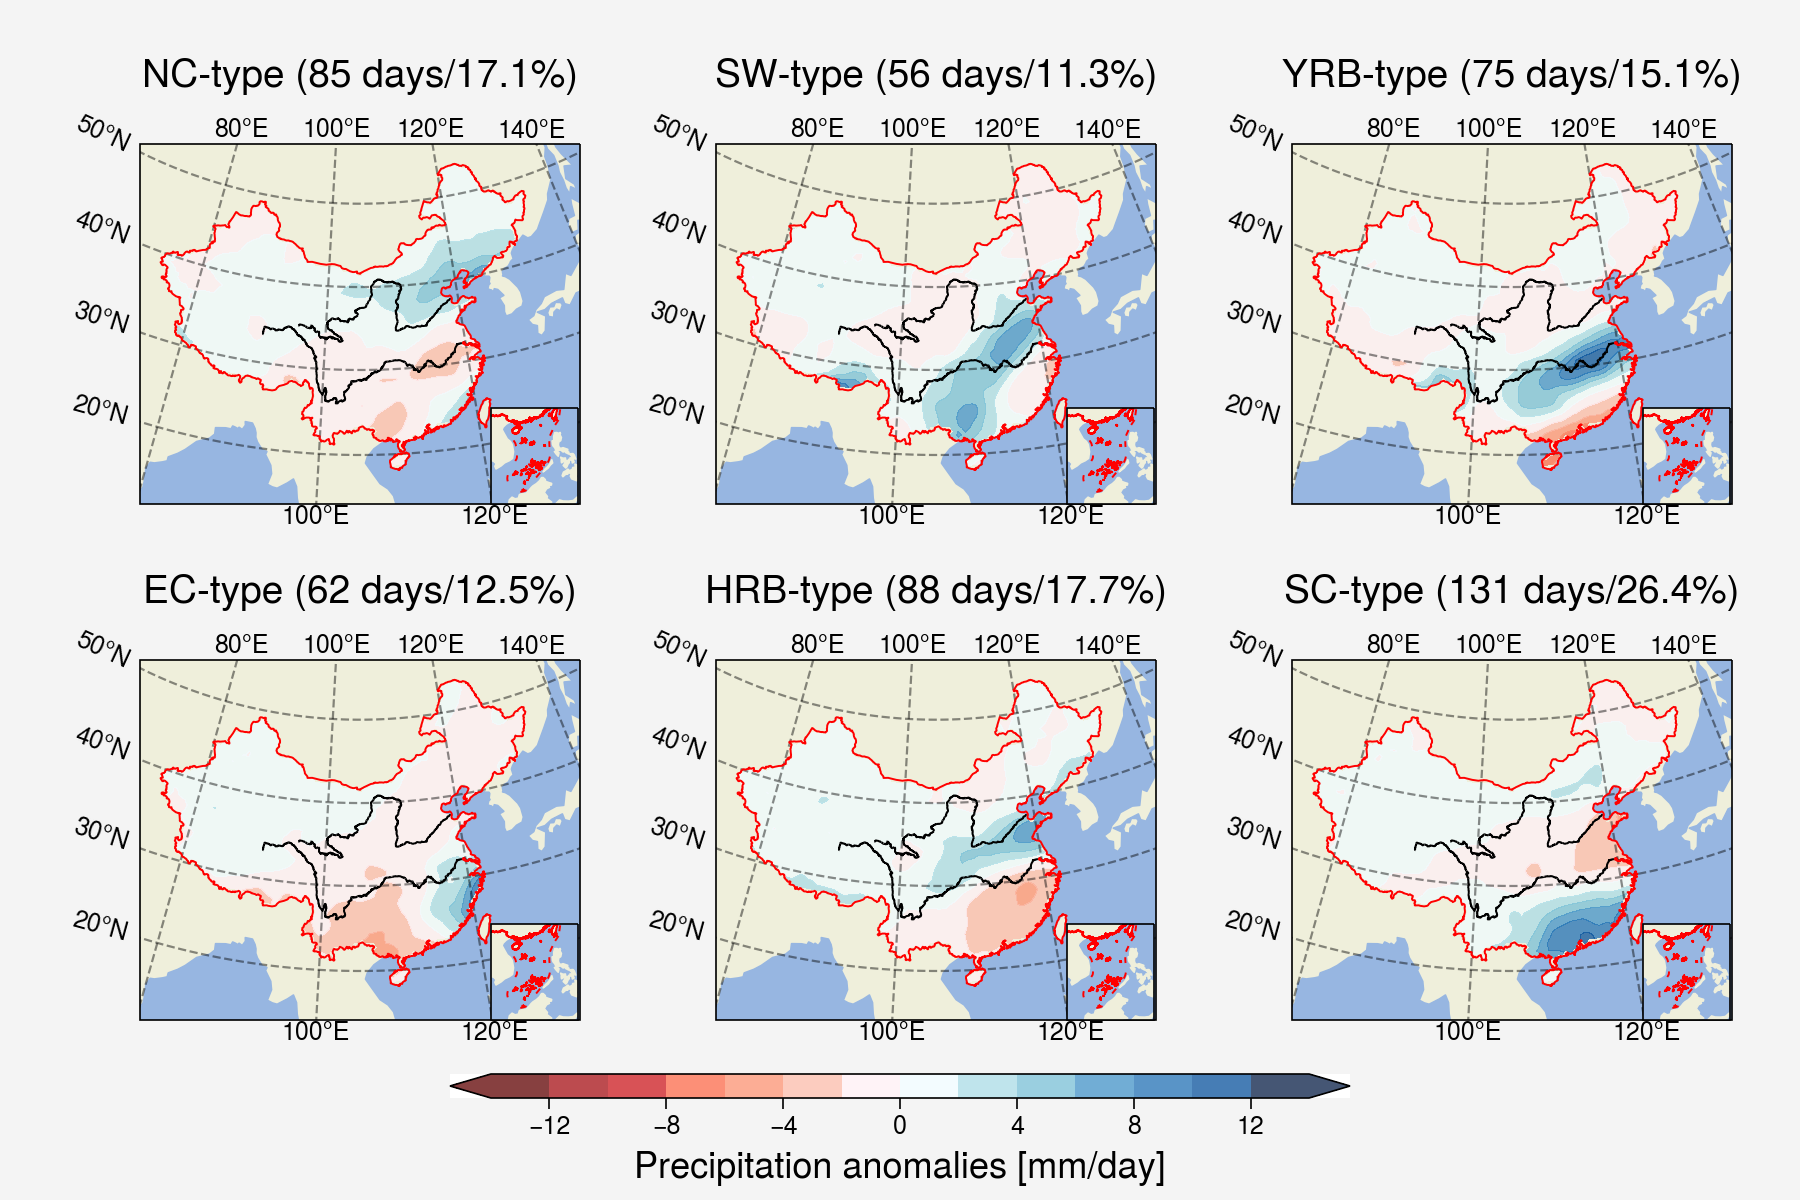

In [59]:
# determine winner by applying SOM analysis to the CMIP6 historical simulation
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
levels = [-14 + 2 * i for i in range(15)]
# cmap1 = cmaps.temp_diff_18lev_r
cmap1 = cmaps.temp_19lev_r

axes_locs = [
    [0.05,0.58,0.3,0.3],
    [0.37,0.58,0.3,0.3],
    [0.69,0.58,0.3,0.3],
    [0.05,0.15,0.3,0.3],
    [0.37,0.15,0.3,0.3],
    [0.69,0.15,0.3,0.3],
]
subaxes_locs = [
    [0.22 + 0.027, 0.58, 0.1, 0.08],
    [0.55 + 0.017, 0.58, 0.1, 0.08],
    [0.88 + 0.007, 0.58, 0.1, 0.08],
    [0.22 + 0.027, 0.15, 0.1, 0.08],
    [0.55 + 0.017, 0.15, 0.1, 0.08],
    [0.88 + 0.007, 0.15, 0.1, 0.08]
]
types = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

fig = plt.figure(figsize = (9,6))
for i in range(6):
    ax1 = fig.add_axes(axes_locs[i], projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner_2==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    # ax1.set_title('SOM Pattern '+str(i + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
    ax1.set_title(types[i]+' ('+str(sum(winner_2==i))+' days/'+'{:.1%}'.format(sum(winner_2==i)/len(winner_2))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    sub_ax = fig.add_axes(subaxes_locs[i], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
    sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
    sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
    for line in borders:
        sub_ax.plot(line[0::2], line[1::2], '-', color='r',transform=ccrs.Geodetic(),linewidth=0.7)
    sub_ax.set_extent([105, 125, 0, 25])

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

# set colorbar
cbar_ax = fig.add_axes([0.25, 0.085, 0.5, 0.02])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Precipitation anomalies [mm/day]',fontdict={'fontsize': 13, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

fig_dir = 'figure/'
# fig.savefig(fig_dir + "anomalous_precipitation_cluster_CESM2.pdf")

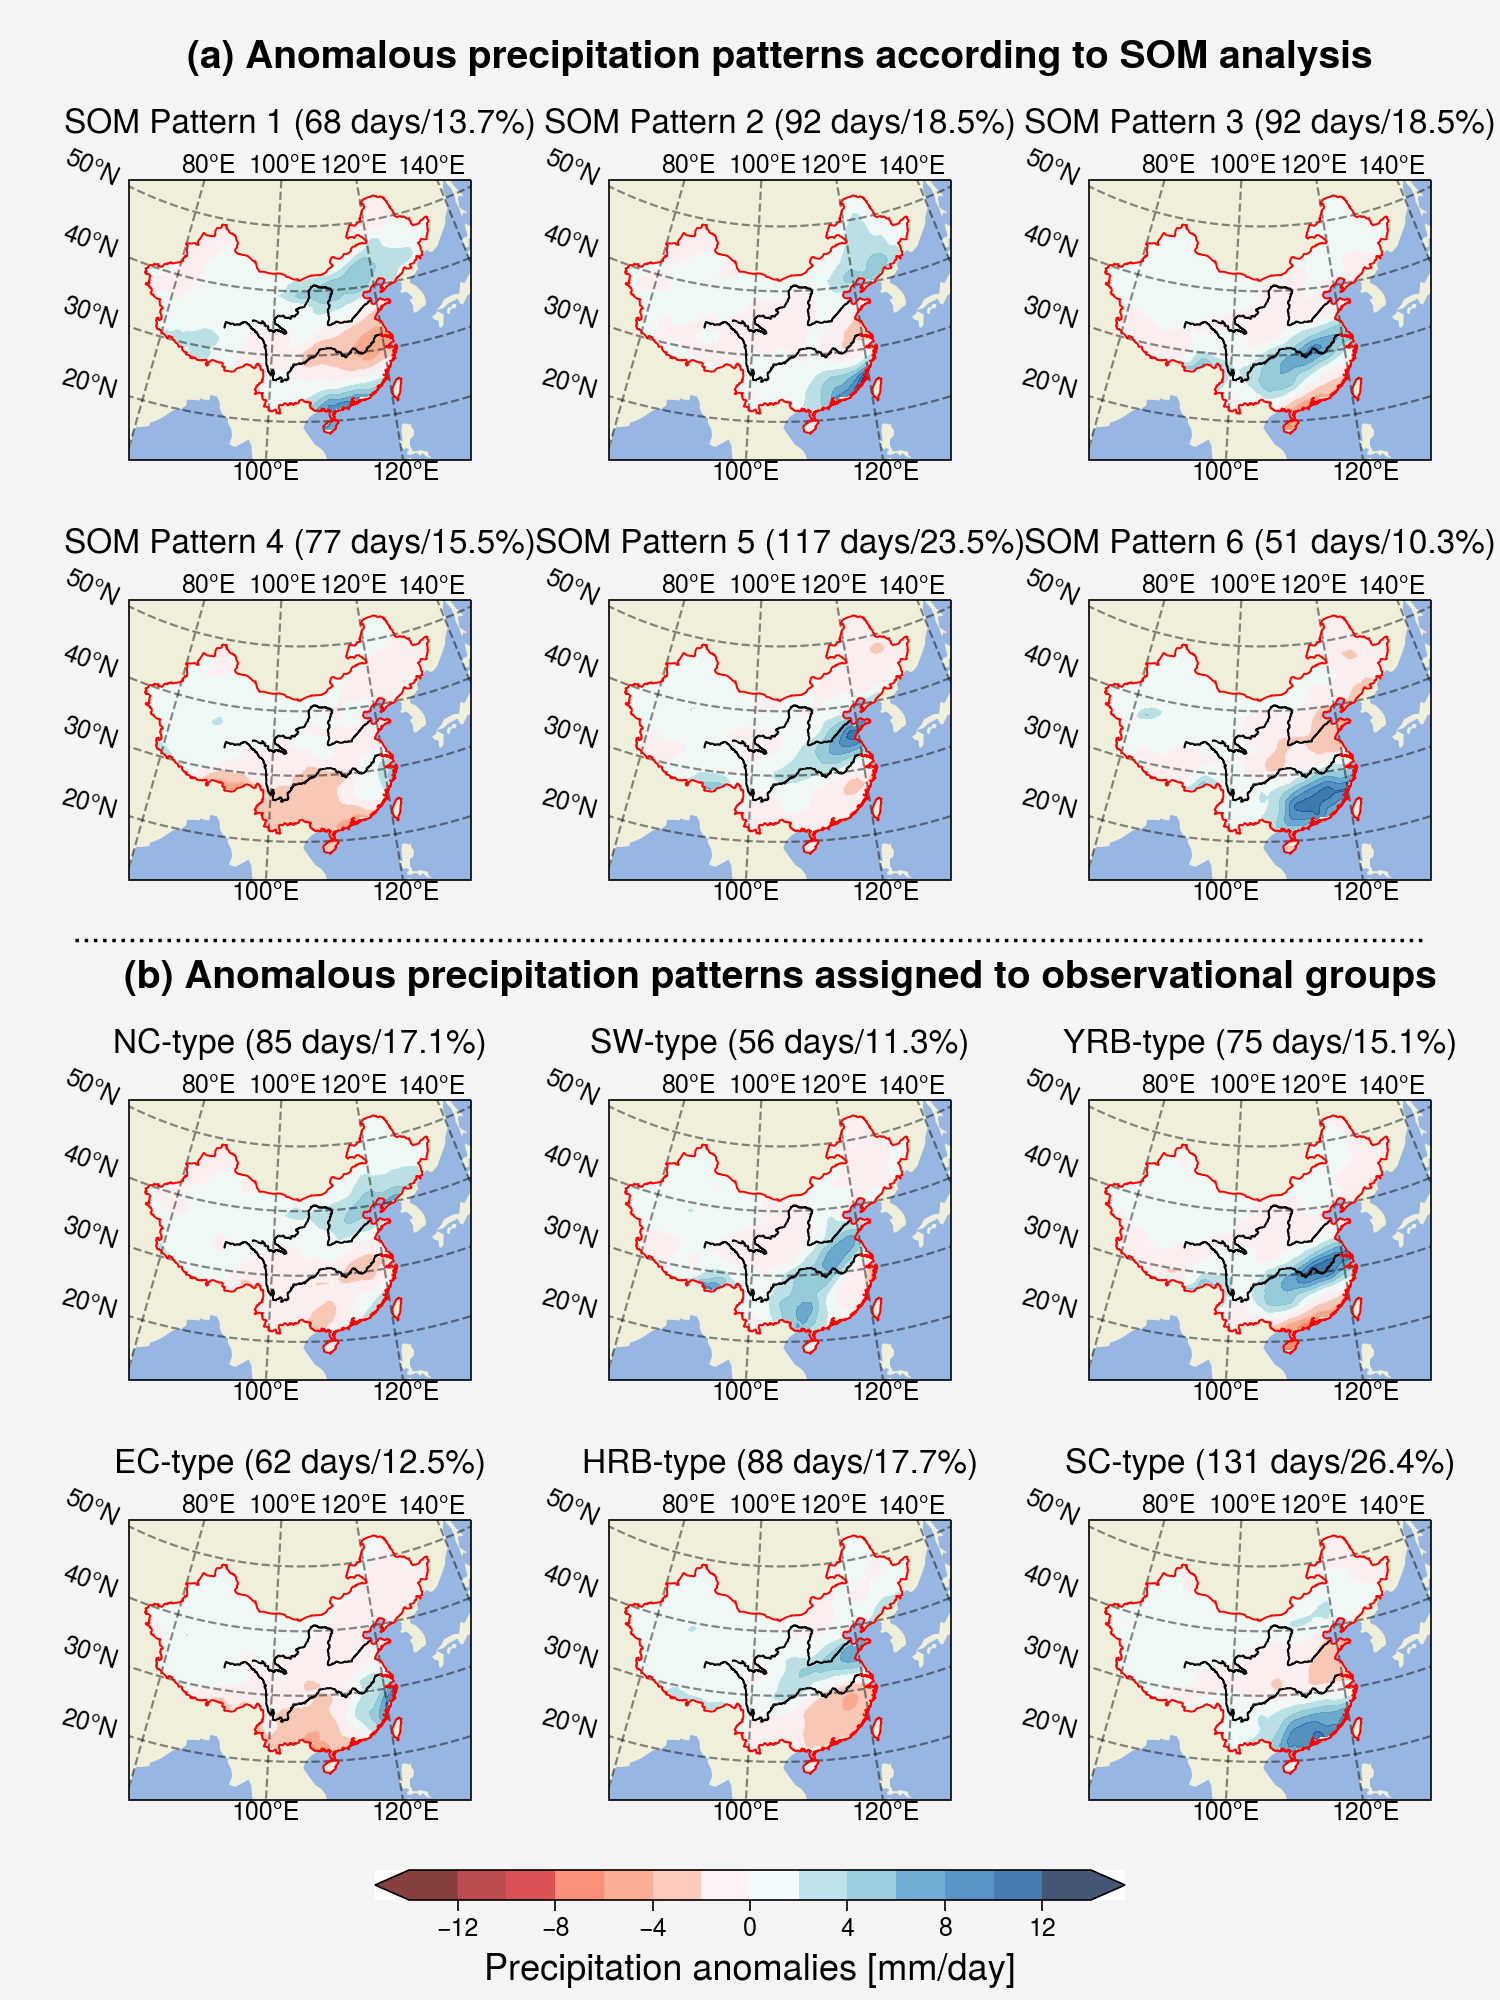

In [80]:
# determine winner by applying SOM analysis to the CMIP6 historical simulation
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
levels = [-14 + 2 * i for i in range(15)]
# cmap1 = cmaps.temp_diff_18lev_r
cmap1 = cmaps.temp_19lev_r

axes_locs = [
    [0.05,0.77,0.3,0.14],
    [0.37,0.77,0.3,0.14],
    [0.69,0.77,0.3,0.14],

    [0.05,0.56,0.3,0.14],
    [0.37,0.56,0.3,0.14],
    [0.69,0.56,0.3,0.14],

    [0.05,0.31,0.3,0.14],
    [0.37,0.31,0.3,0.14],
    [0.69,0.31,0.3,0.14],

    [0.05,0.1,0.3,0.14],
    [0.37,0.1,0.3,0.14],
    [0.69,0.1,0.3,0.14],
]

types = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

fig = plt.figure(figsize = (7.5,10))
for i in range(6):
    if i == 0:
        a = 4
        loc = axes_locs[a]
    elif i == 1:
        a = 1
        loc = axes_locs[a]
    elif i == 2:
        a = 2
        loc = axes_locs[a]
    elif i == 3:
        a = 5
        loc = axes_locs[a]
    elif i == 4:
        a = 3
        loc = axes_locs[a]
    elif i == 5:
        a = 0
        loc = axes_locs[a]
    ax1 = fig.add_axes(loc, projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    ax1.set_title('SOM Pattern '+str(a + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
    # ax1.set_title(types[i]+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

    if i == 1:
        ax1.text(0.5,1.4,"(a) Anomalous precipitation patterns according to SOM analysis",transform=ax1.transAxes,fontsize=14,fontweight='bold',horizontalalignment='center')

for i in range(6):
    ax1 = fig.add_axes(axes_locs[i+6], projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner_2==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    # ax1.set_title('SOM Pattern '+str(i + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
    ax1.set_title(types[i]+' ('+str(sum(winner_2==i))+' days/'+'{:.1%}'.format(sum(winner_2==i)/len(winner_2))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

    if i == 1:
        ax1.text(0.5,1.4,"(b) Anomalous precipitation patterns assigned to observational groups",transform=ax1.transAxes,fontsize=14,fontweight='bold',horizontalalignment='center')

# set colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.015])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Precipitation anomalies [mm/day]',fontdict={'fontsize': 13, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

line1 = plt.Line2D((.05,0.95),(.53,0.53), color="k", linewidth=1.25, linestyle=':')
fig.add_artist(line1) ## add separate line

fig_dir = 'figure/'
fig.savefig(fig_dir + "anomalous_precipitation_cluster_CESM2.pdf")

# SOM applied to BCC-CSM2-MR simulation

In [130]:
prec_ano = xr.open_dataarray('output/historical_pr_NorESM2-MM_1961_2014_summer_anomalies.nc')
hist_time = pd.date_range(start='1961-01-01',end='2014-12-31',freq='D')
hist_time = hist_time[(hist_time.month > 4) & (hist_time.month < 11)]
prec_ano['time'] = hist_time
ano_date = pd.read_csv('output/ano_dates_95th_NorESM2-MM.csv',index_col=0,header=0)
ano_date = pd.to_datetime(ano_date.index,format='%Y-%m-%d')
prec_ano_95th = prec_ano.sel(time = ano_date)

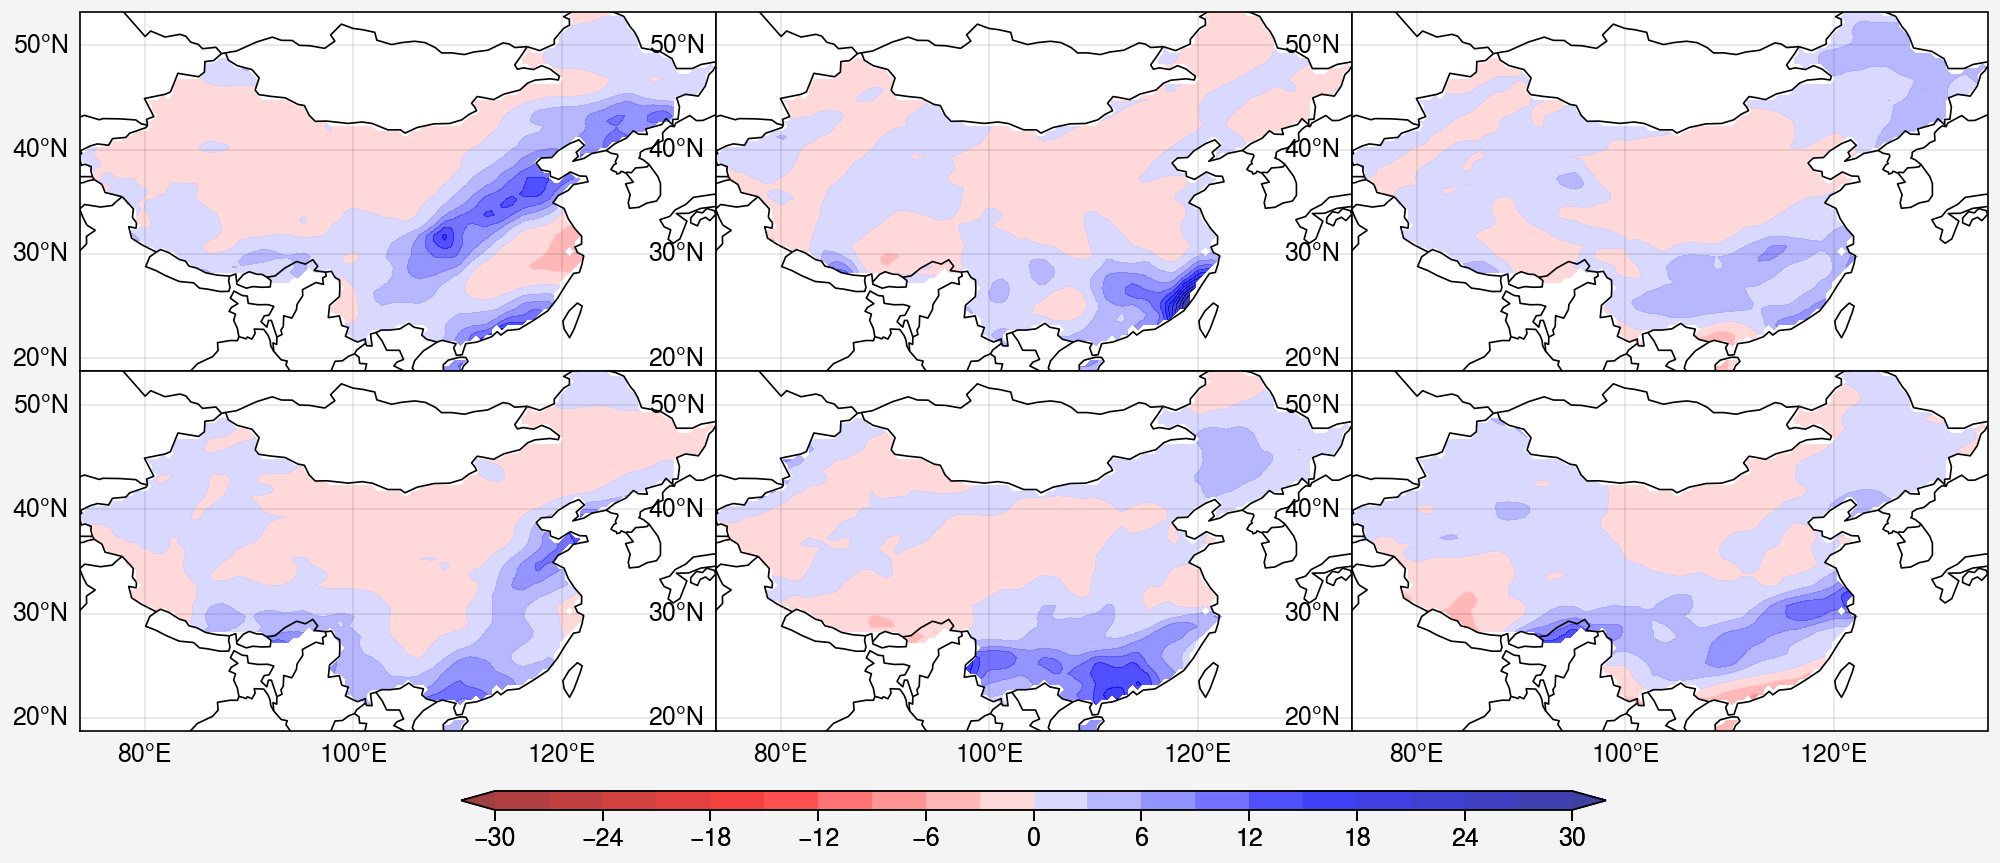

In [131]:
som_analysis(prec_ano_95th,2,3)

## SOM pattern statistics

In [132]:
winner = determine_winner_1(prec_ano_95th)
winner = np.array(winner)

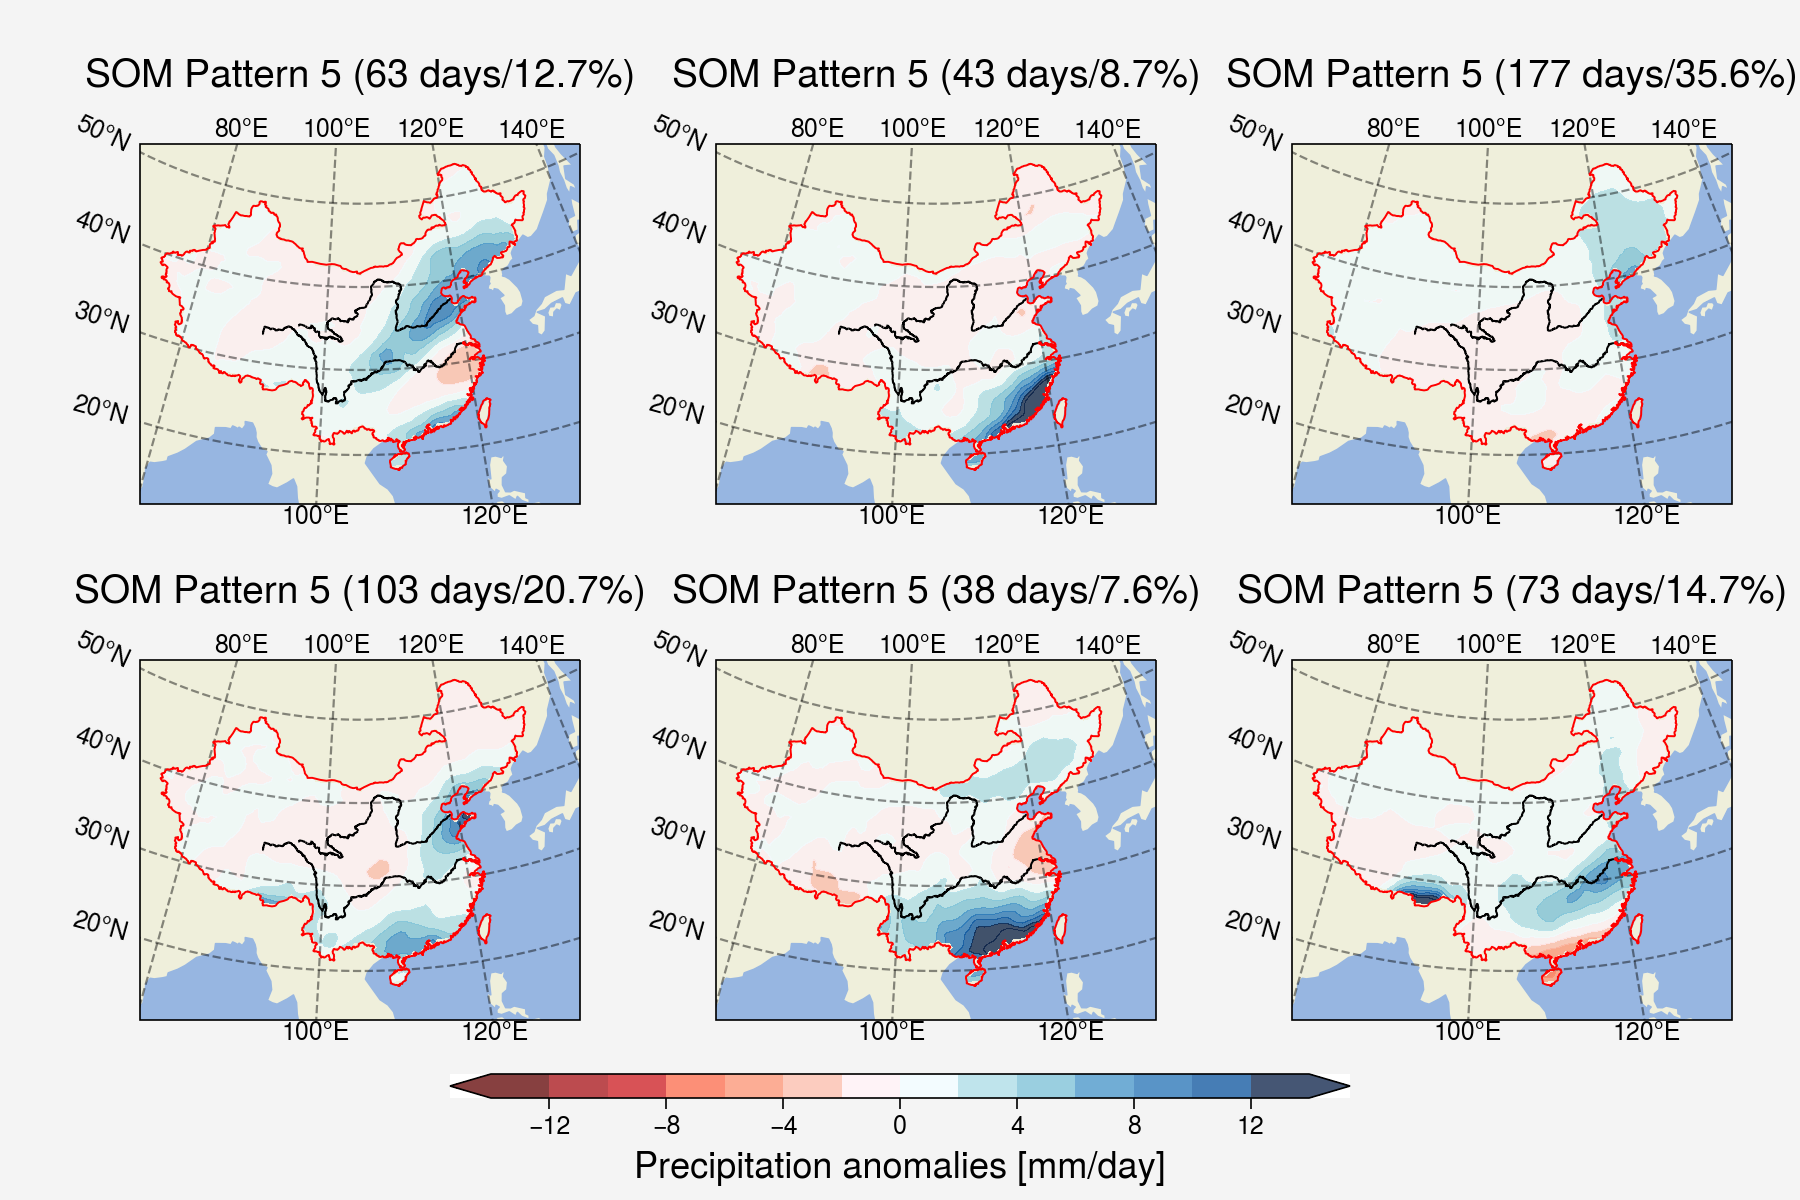

In [138]:
# determine winner by applying SOM analysis to the CMIP6 historical simulation
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
levels = [-14 + 2 * i for i in range(15)]
# cmap1 = cmaps.temp_diff_18lev_r
cmap1 = cmaps.temp_19lev_r

axes_locs = [
    [0.05,0.58,0.3,0.3],
    [0.37,0.58,0.3,0.3],
    [0.69,0.58,0.3,0.3],
    [0.05,0.15,0.3,0.3],
    [0.37,0.15,0.3,0.3],
    [0.69,0.15,0.3,0.3],
]
types = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

fig = plt.figure(figsize = (9,6))
for i in range(6):
    ax1 = fig.add_axes(axes_locs[i], projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    ax1.set_title('SOM Pattern '+str(a + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)
    # ax1.set_title(types[i]+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

# set colorbar
cbar_ax = fig.add_axes([0.25, 0.085, 0.5, 0.02])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Precipitation anomalies [mm/day]',fontdict={'fontsize': 13, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar


In [134]:
winner_2 = determine_winner_2(prec_ano_95th)
winner_2 = np.array(winner_2)

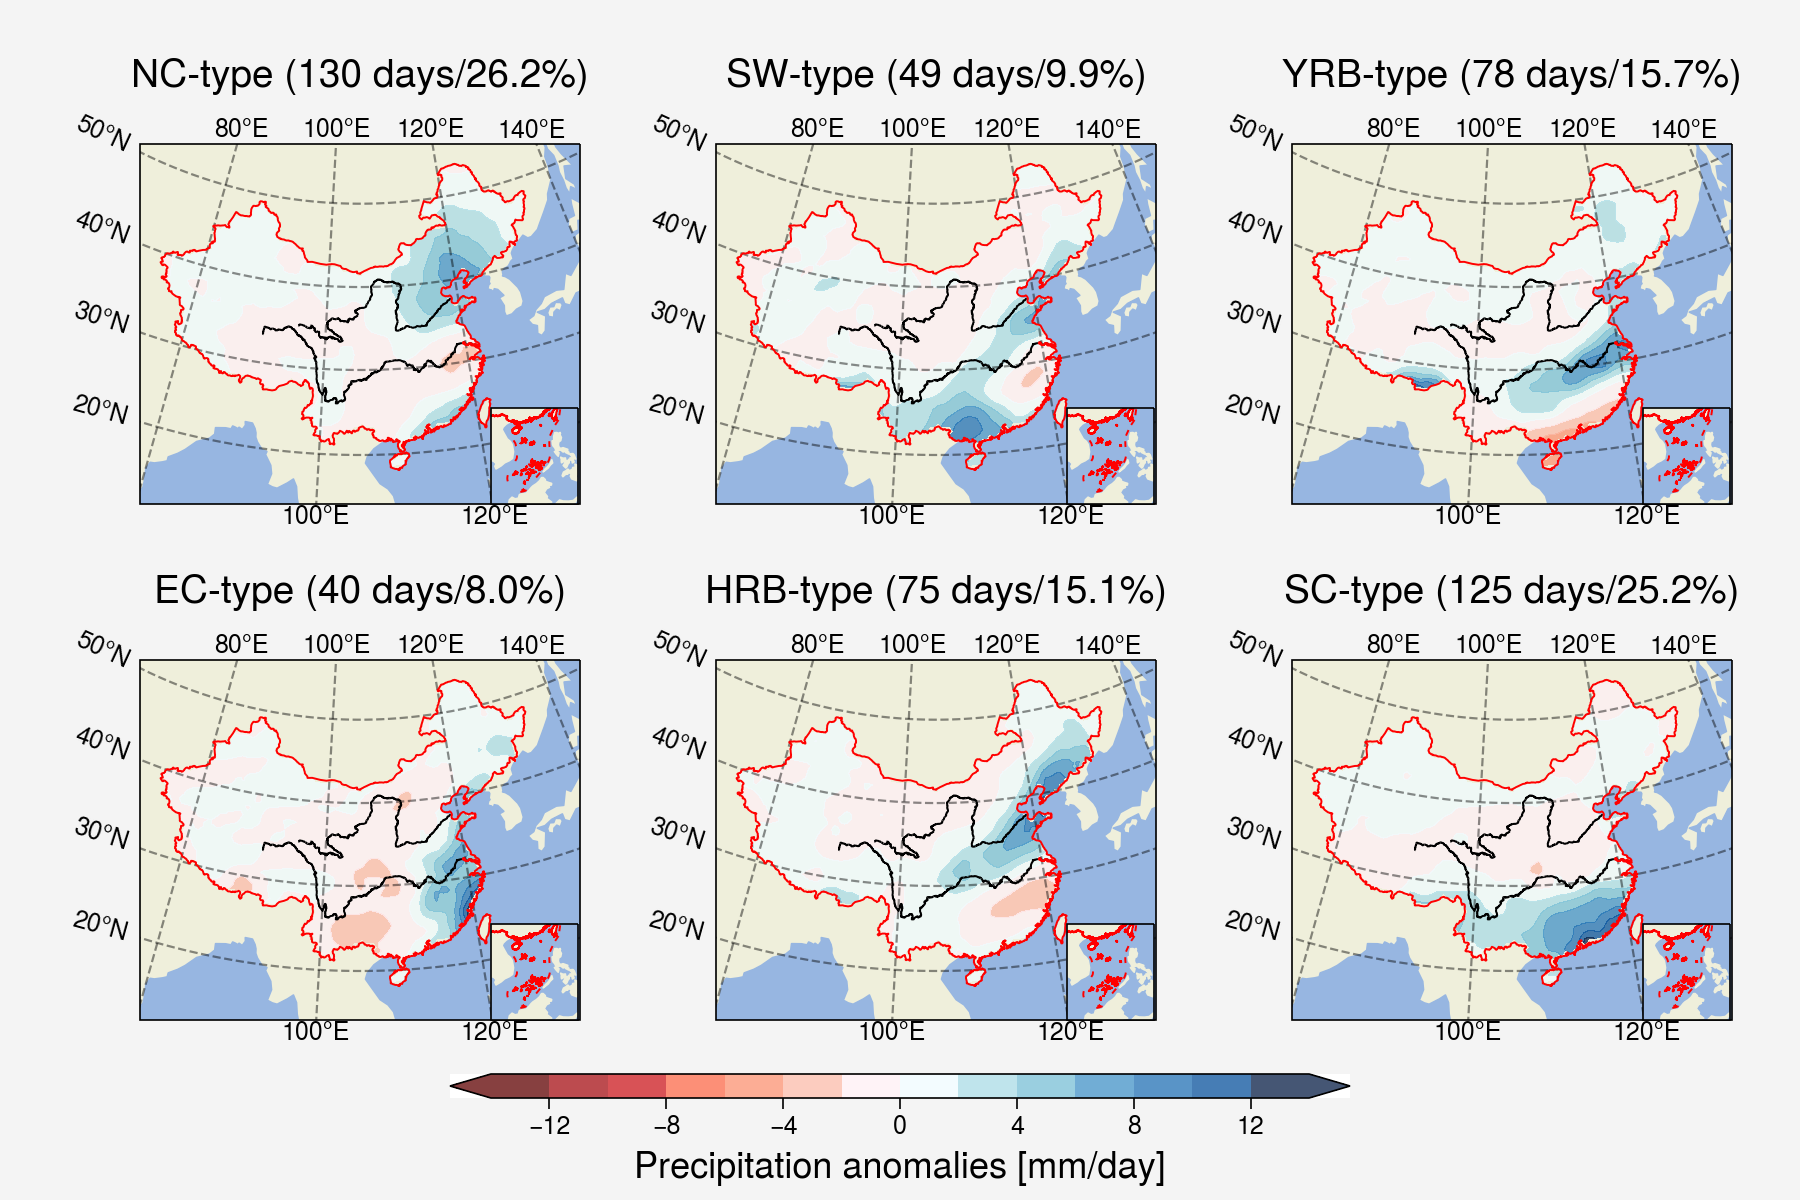

In [135]:
# determine winner by applying SOM analysis to the CMIP6 historical simulation
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
levels = [-14 + 2 * i for i in range(15)]
# cmap1 = cmaps.temp_diff_18lev_r
cmap1 = cmaps.temp_19lev_r

axes_locs = [
    [0.05,0.58,0.3,0.3],
    [0.37,0.58,0.3,0.3],
    [0.69,0.58,0.3,0.3],
    [0.05,0.15,0.3,0.3],
    [0.37,0.15,0.3,0.3],
    [0.69,0.15,0.3,0.3],
]
subaxes_locs = [
    [0.22 + 0.027, 0.58, 0.1, 0.08],
    [0.55 + 0.017, 0.58, 0.1, 0.08],
    [0.88 + 0.007, 0.58, 0.1, 0.08],
    [0.22 + 0.027, 0.15, 0.1, 0.08],
    [0.55 + 0.017, 0.15, 0.1, 0.08],
    [0.88 + 0.007, 0.15, 0.1, 0.08]
]
types = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

fig = plt.figure(figsize = (9,6))
for i in range(6):
    ax1 = fig.add_axes(axes_locs[i], projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner_2==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    # ax1.set_title('SOM Pattern '+str(i + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
    ax1.set_title(types[i]+' ('+str(sum(winner_2==i))+' days/'+'{:.1%}'.format(sum(winner_2==i)/len(winner_2))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    sub_ax = fig.add_axes(subaxes_locs[i], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
    sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
    sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
    for line in borders:
        sub_ax.plot(line[0::2], line[1::2], '-', color='r',transform=ccrs.Geodetic(),linewidth=0.7)
    sub_ax.set_extent([105, 125, 0, 25])

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

# set colorbar
cbar_ax = fig.add_axes([0.25, 0.085, 0.5, 0.02])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Precipitation anomalies [mm/day]',fontdict={'fontsize': 13, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar


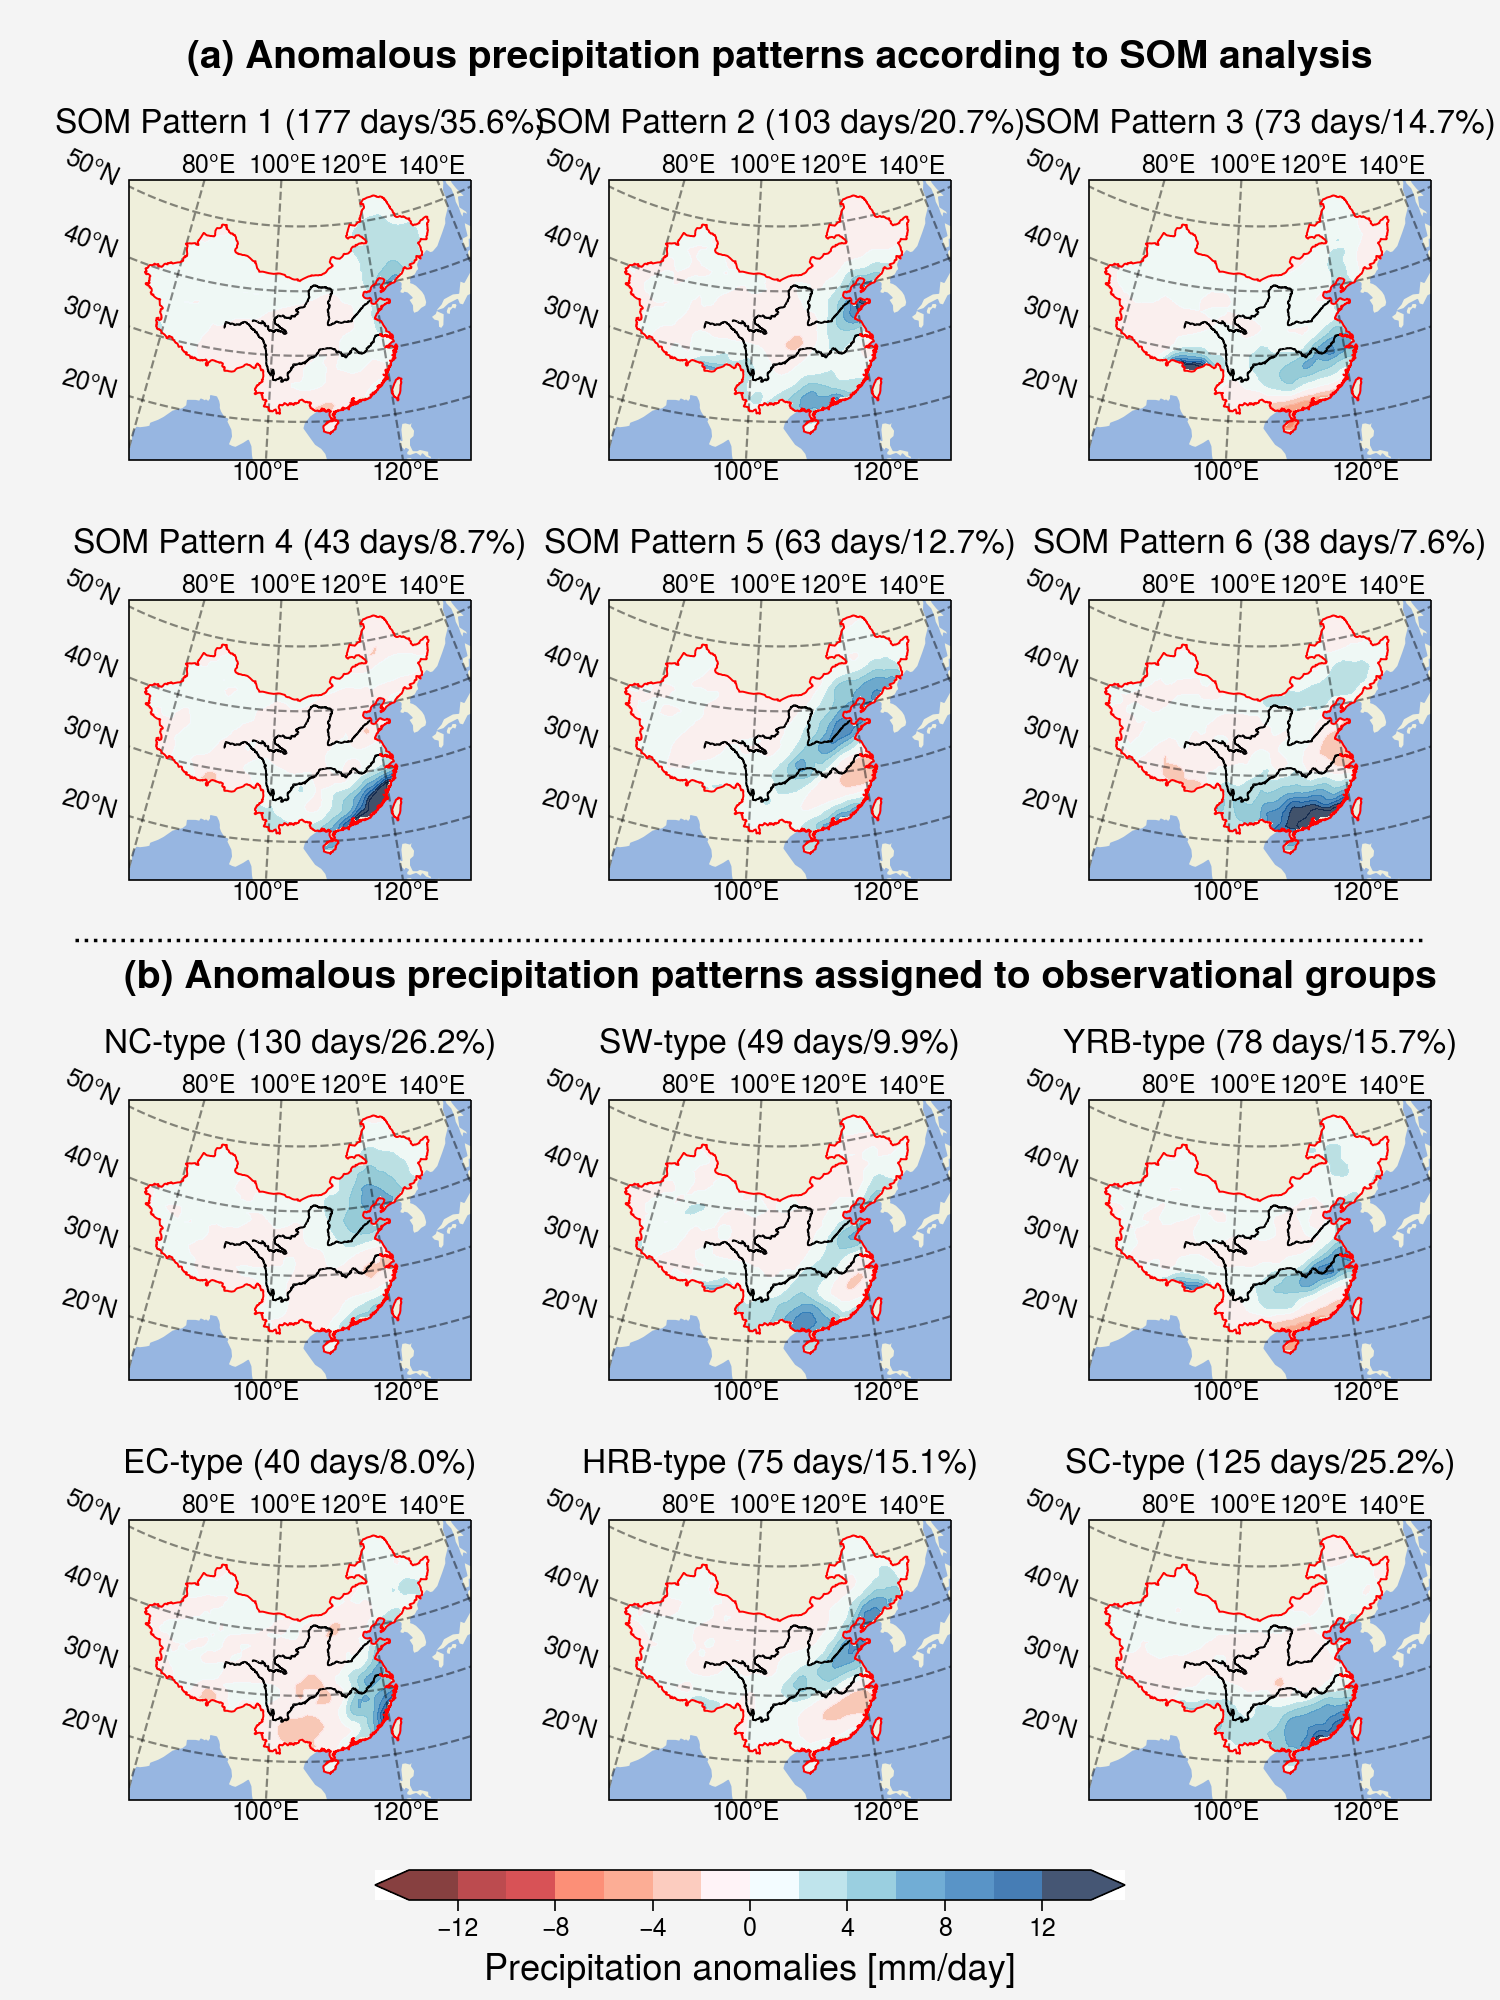

In [141]:
# determine winner by applying SOM analysis to the CMIP6 historical simulation
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
levels = [-14 + 2 * i for i in range(15)]
# cmap1 = cmaps.temp_diff_18lev_r
cmap1 = cmaps.temp_19lev_r

axes_locs = [
    [0.05,0.77,0.3,0.14],
    [0.37,0.77,0.3,0.14],
    [0.69,0.77,0.3,0.14],

    [0.05,0.56,0.3,0.14],
    [0.37,0.56,0.3,0.14],
    [0.69,0.56,0.3,0.14],

    [0.05,0.31,0.3,0.14],
    [0.37,0.31,0.3,0.14],
    [0.69,0.31,0.3,0.14],

    [0.05,0.1,0.3,0.14],
    [0.37,0.1,0.3,0.14],
    [0.69,0.1,0.3,0.14],
]

types = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

fig = plt.figure(figsize = (7.5,10))
for i in range(6):
    if i == 0:
        a = 4
        loc = axes_locs[a]
    elif i == 1:
        a = 3
        loc = axes_locs[a]
    elif i == 2:
        a = 0
        loc = axes_locs[a]
    elif i == 3:
        a = 1
        loc = axes_locs[a]
    elif i == 4:
        a = 5
        loc = axes_locs[a]
    elif i == 5:
        a = 2
        loc = axes_locs[a]
    ax1 = fig.add_axes(loc, projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    ax1.set_title('SOM Pattern '+str(a + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
    # ax1.set_title(types[i]+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

    if a == 1:
        ax1.text(0.5,1.4,"(a) Anomalous precipitation patterns according to SOM analysis",transform=ax1.transAxes,fontsize=14,fontweight='bold',horizontalalignment='center')

for i in range(6):
    ax1 = fig.add_axes(axes_locs[i+6], projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner_2==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    # ax1.set_title('SOM Pattern '+str(i + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
    ax1.set_title(types[i]+' ('+str(sum(winner_2==i))+' days/'+'{:.1%}'.format(sum(winner_2==i)/len(winner_2))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

    if i == 1:
        ax1.text(0.5,1.4,"(b) Anomalous precipitation patterns assigned to observational groups",transform=ax1.transAxes,fontsize=14,fontweight='bold',horizontalalignment='center')

# set colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.015])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Precipitation anomalies [mm/day]',fontdict={'fontsize': 13, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

line1 = plt.Line2D((.05,0.95),(.53,0.53), color="k", linewidth=1.25, linestyle=':')
fig.add_artist(line1) ## add separate line

fig_dir = 'figure/'
fig.savefig(fig_dir + "anomalous_precipitation_cluster_NorESM2-MM.pdf")